In [0]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [37]:
from google.colab import drive
drive.mount('/gdrive')
os.chdir('/gdrive/My Drive/NLAProject')
path_to_file = '/gdrive/My Drive/NLAProject/Corpus/v2/final_output.txt'
testing_file = '/gdrive/My Drive/NLAProject/Corpus/v2/normal_aligned.txt'
target_file = '/gdrive/My Drive/NLAProject/Corpus/v2/simple_aligned.txt'


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)
  w = re.sub(r"[^a-zA-Z0-9?.!,¿]+", " ", w)
  w = w.strip()
  w = '<start> ' + w + ' <end>'
  return w

In [0]:
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [0]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [0]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  inp_lang, targ_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
  print(inp_lang[1], targ_lang[1])
  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [42]:
num_examples = 15000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)
print(inp_lang, targ_lang)

max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
print(max_length_targ, max_length_inp)

<start> cherokee is a city in alfalfa county , oklahoma , united states . <end> <start> cherokee is a city of oklahoma in the united states . <end>
<keras_preprocessing.text.Tokenizer object at 0x7fd1ea3a6fd0> <keras_preprocessing.text.Tokenizer object at 0x7fd1cfe04eb8>
174 207


In [43]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

12000 12000 3000 3000


In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [45]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
4 ----> <start>
18 ----> on
408 ----> 19
178 ----> october
334 ----> 2010
2 ----> ,
13344 ----> swenson
10174 ----> granite
2 ----> ,
191 ----> based
7 ----> in
6713 ----> concord
2 ----> ,
64 ----> new
5083 ----> hampshire
2 ----> ,
677 ----> announced
22 ----> that
21 ----> it
9 ----> and
268 ----> rock
6 ----> of
2484 ----> ages
59 ----> had
2414 ----> agreed
11 ----> to
20874 ----> merge
3 ----> .
13344 ----> swenson
2928 ----> paid
268 ----> rock
6 ----> of
2484 ----> ages
13345 ----> shareholders
8 ----> a
484 ----> total
6 ----> of
3546 ----> 39
330 ----> million
3 ----> .
5 ----> <end>

Target Language; index to word mapping
4 ----> <start>
7 ----> in
180 ----> october
388 ----> 2010
3 ----> ,
248 ----> another
3473 ----> mining
243 ----> company
3 ----> ,
18665 ----> swenson
8925 ----> granite
243 ----> company
3 ----> ,
145 ----> said
15 ----> it
144 ----> would
2794 ----> buy
266 ----> rock
6 ----> of
2622 ----> ages
16 ----> for
3340 --

Batch size is less because of GPU issues


In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 8
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 256
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [47]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([8, 207]), TensorShape([8, 174]))

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [49]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (8, 207, 256)
Encoder Hidden state shape: (batch size, units) (8, 256)


In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [51]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (8, 256)
Attention weights shape: (batch_size, sequence_length, 1) (8, 207, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)

    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    output, state = self.gru(x)
    output = tf.reshape(output, (-1, output.shape[2]))

    x = self.fc(output)

    return x, state, attention_weights

In [53]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (8, 28202)


In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer = optimizer, encoder = encoder, decoder = decoder)

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    for t in range(1, targ.shape[1]):
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
      loss += loss_function(targ[:, t], predictions)
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [0]:
EPOCHS = 5

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [0]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))
  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen = max_length_inp, padding = 'post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  result_words = []
  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()
    result += targ_lang.index_word[predicted_id] + ' '
    result_words.append(targ_lang.index_word[predicted_id])

    # if len(result_words) > 5:
    #   for i in range(len(result_words)):
    #     for j in range(i+1, len(result_words)-2):
    #       if result_words[i] == result_words[j] and result_words[i+1] == result_words[j+1] and result_words[i+2] == result_words[j+2]:
    #         return result, sentence, attention_plot 
          

    if len(result) >= len(sentence):
      return result, sentence, attention_plot
    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [0]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [0]:
def translate(sentence):
  # print(sentence)
  result, sentence, attention_plot = evaluate(sentence)
  print('Input sentence: ', sentence)
  # result = '<start> ' + result
  print('Predicted translation: {}'.format(result))
  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [0]:
import nltk
total_BLEU = []
def translate_bleu(sentence, target):
  result, sentence, attention_plot = evaluate(sentence)
  result = '<start> ' + result
  BLEUscore = nltk.translate.bleu_score.sentence_bleu([result], sentence, smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method7)
  if BLEUscore > 0.25:
    print('Input: %s' % (sentence))
  # result = ''
    print('Target sentence: ', target)
    print('Predicted translation: {}'.format(result))
    print(BLEUscore)
    print('\n')
  total_BLEU.append(BLEUscore)
  # print(total_BLEU)
  # attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  # plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [72]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input sentence:  <start> it is the county seat of alfalfa county of the united states . <end>
Predicted translation: it is the county seat of iowa in the united states . <end> 


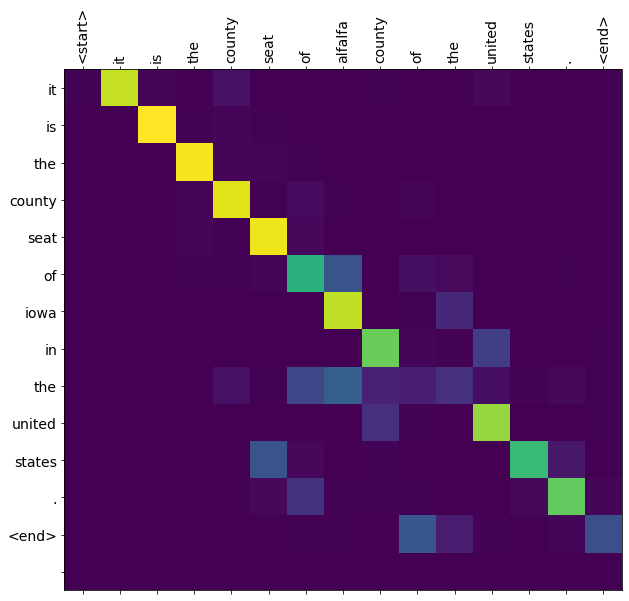

Input sentence:  <start> this template will categorize into different parts . <end>
Predicted translation: this template will be divided into different parts . <end> 


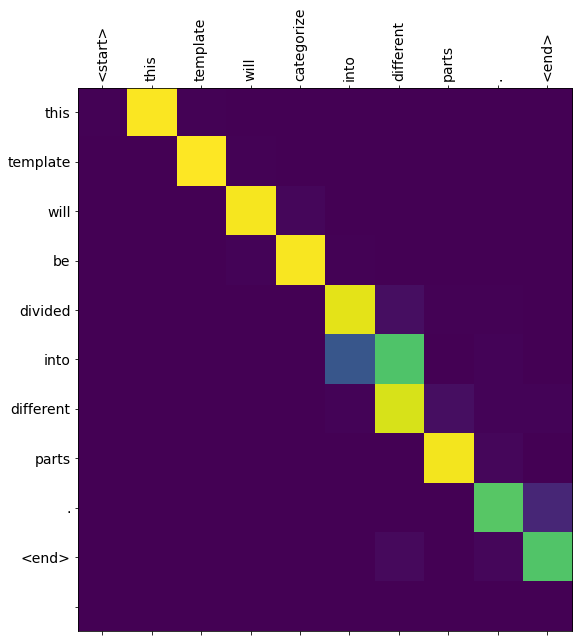

Input sentence:  <start> he has played for japan national team . <end>
Predicted translation: he has played for japan national team . <end> 


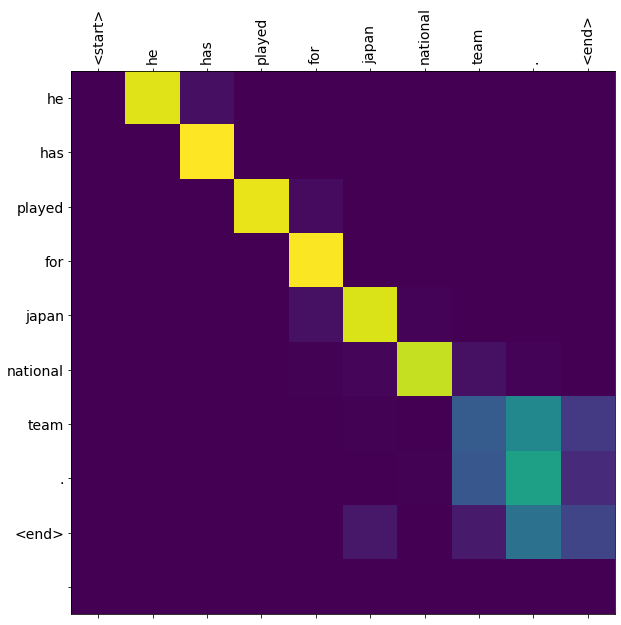

Input sentence:  <start> bossancourt is a commune in the aube department in north central france . <end>
Predicted translation: ha is a commune . it is found in the north central part of france . <end> 


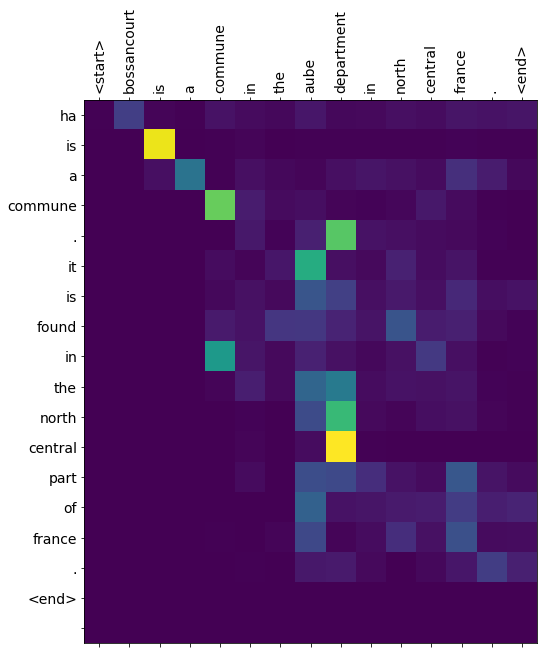

In [73]:
translate('It is the county seat of Alfalfa County of the United States .')
translate('This template will categorize into different parts.')
translate('He has played for Japan national team . ')
translate('Bossancourt is a commune in the aube department in north central france .')

In [0]:
# translate('kesswil is a municipality in the district of arbon in the canton of thurgau in switzerland .')
# translate('citrus county is a county located in the u.s. state of florida .')
# translate('cestas is a commune in the gironde department in aquitaine in south western france .')

In [0]:
# translate('the french were successful in reconquering milan two years later , however .')
# translate(' port de paix is also the chief town of an arrondissement of the same name .')
# translate('Neural models are giving better outputs than statistical models .')

In [0]:
total_BLEU = []
num = 0
aligned_sentences = {}

final_file = open(path_to_file, 'r')
lines = final_file.readlines()
for line in lines:
  if num < 100:
    aligned_sentences[line.split('\t')[0]] = line.split('\t')[1]
    num += 1

In [0]:
# for key, value in aligned_sentences.items():
#   translate_bleu(key, value.lower())
  # print(key, value)

In [0]:
# summ = 0
# print(len(total_BLEU))
# for i in range(len(total_BLEU)):
#   summ += total_BLEU[i]
# print(summ/len(total_BLEU))